In [1]:
import sys
sys.path.append('../')

import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from IPython.display import display, Math
from gqco.train import MyModel
from gqco.utils import fix_seed, arange_token
from gqco.data import generate_adj, data_from_adj
from gqco.solve import solve_from_token, plot_from_dict, adj_to_text
from gqco.model import TransformerWithMoE


## Load the model

In [ ]:
task_path = '../model/taskobjects.pkl'
checkpoint_path = '../model/model.ckpt'
seed=0

with open(task_path, 'rb') as f: 
    obj = pickle.load(f)
gqco = obj['task']
args = obj['args']

model = TransformerWithMoE(args)
model = MyModel.load_from_checkpoint(checkpoint_path, model=model, task=gqco, args=args)
try:
    model = model.to('cuda')
    device = model.device
except:
    device = torch.device('cpu')


## Problem setup

In [3]:
seed = 0


### (Option 1) Input your problem as a Hamiltonian coefficient matrix.
Example:

If, your Ising Hamiltonian is: 
$$
\begin{align*}
    \mathcal{H} = \sum_{i=1}^3 h_i \sigma_{i} + \sum_{i > j} J_{ij} \sigma_{i} \sigma_{j},
\end{align*}
$$
then, define
$$
\begin{align}
    \mathrm{adj} = \left[ \begin{array}{ccc} h_1 & J_{12} & J_{13} \\ 0 & h_{2} & J_{23} \\ 0 & 0 & h_{3} \end{array} \right].
\end{align}
$$

Note that the coefficients must be scaled so that the maximum absolute value of the coefficients is exactly 1.

In [4]:
adj = torch.tensor([
    [-0.30, 0.40, 0.01],
    [ 0.00, 1.00, 0.90],
    [ 0.00, 0.00, 0.25],
])
adj = adj / torch.max(torch.abs(adj))


### (Option 2) Generate random coefficients
Please specify the problem size and the random seed.

Note that the function `generate_adj` automalically scale the coefficients. 

In [ ]:
size = 3
adj = generate_adj(size, seed=seed, device=device)


## Solve the problem

You will get the following objects:
- `token_min`: The generated token sequence that has the smallest energy among the sampled circuits.
- `energy_min`: The energy value computed using the `token_min` circuit.
- `dict_pred`: The probability amplitude of the quantum state of the generated circuit. This is a Python dictionary, e.g., `{'00': 0.9, '11': 0.1}`.
- `dict_true`: A Python dictionary representing the cost of the combinatorial optimization problem for each computational basis state.
- `qc`: A quantum circuit object. You can access the Qiskit (or cudaq) circuit object via `qc.qc`.

-- Objective --


<IPython.core.display.Math object>



-- Token --
[61, 61, 61, 1540, 281, 1521]


-- Circuit --


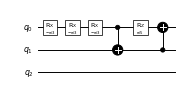



-- Transpiled circuit --


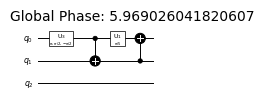

-- Histogram --


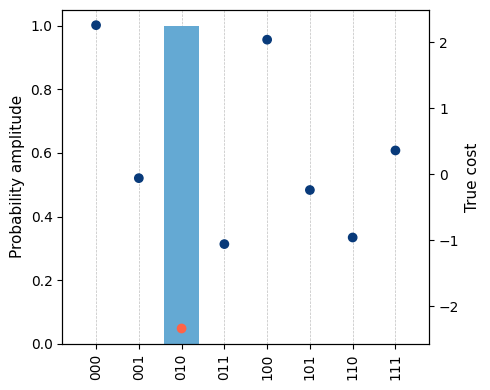

In [ ]:
fix_seed(seed)
model.eval()

## Generate data
adj, size, record = data_from_adj(adj.to(device), 100, device)

## Generate circuits
with torch.no_grad():
    with torch.autocast('cuda'):
        out_tokens, probs_all, _, logits_all = model.forward(record, temperature=2.0)
tokens_list = [arange_token(t, args) for t in out_tokens.detach().tolist()]
energies = [gqco.compute_energy(t, adj, args.num_shot) for t in tokens_list]

## Get the best
idx_min = energies.index(min(energies))
token_min = tokens_list[idx_min]
energy_min = energies[idx_min]

## Make result
print('-- Objective --')
adj_to_text(adj)
print('\n')
dict_pred, dict_true, qc = solve_from_token(gqco, token_min, adj, is_print=True)
print('-- Histogram --')
plot_from_dict(dict_pred, dict_true, savefile=None)  ## If you specify `savefile`, the histogram will be saved at f'{savefile}-probs.svg'.


#### Objects

In [7]:
dict_true


{'000': 2.259999990463257,
 '001': -0.059999942779541016,
 '010': -2.3400001525878906,
 '011': -1.0600000619888306,
 '100': 2.0399999618530273,
 '101': -0.2399999499320984,
 '110': -0.9599999189376831,
 '111': 0.36000001430511475}

In [8]:
dict_pred


{'000': 8.024582750190568e-32,
 '100': 0.0,
 '010': 1.0,
 '110': 0.0,
 '001': 0.0,
 '101': 0.0,
 '011': 0.0,
 '111': 0.0}

In [9]:
qc.qc
